In [3]:
import import_ipynb
import CFModel 
import math
from CFModel import CFModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.models import Sequential
from keras.models import Model
from IPython.display import SVG
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Embedding, Reshape, concatenate, Input, Flatten, dot, Dropout, Dense,BatchNormalization
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.manifold import TSNE
import seaborn as sns
from keras import models
from keras.layers.embeddings import Embedding
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

Using TensorFlow backend.


In [5]:
movies = pd.read_csv('ml-latest-small/movies.csv')

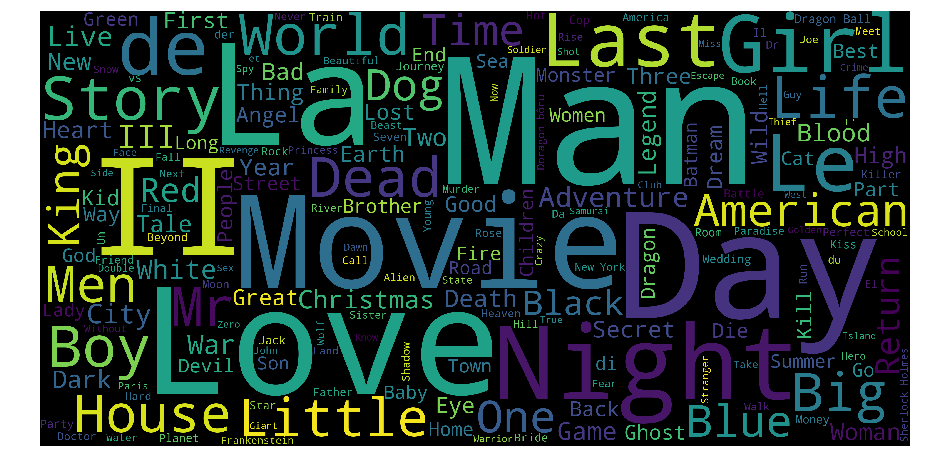

In [6]:
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [7]:
ratings_dataset = pd.read_csv('ml-latest-small/ratings.csv')

In [8]:
popular_movies = ratings_dataset[ratings_dataset.movieId.isin(ratings_dataset.groupby(['movieId']).count().sort_values(by='rating', ascending=False).reset_index()[:500]['movieId'].to_list())]
popular_movies.drop('timestamp', axis=1,inplace=True)

C:\Users\Dell\Anaconda3\envs\data-x\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
popular_movies.shape

(43734, 3)

In [10]:
popular_movies.groupby('movieId').count()

,userId,rating
movieId,,
1,215,215
2,110,110
3,52,52
5,49,49
6,102,102
...,...,...
112852,59,59
116797,50,50
122882,47,47


In [11]:
n_latent_factors = 32
n_users, n_movies = len(popular_movies['userId'].unique()), len(popular_movies['movieId'].unique()) 

In [12]:
n_movies

500

In [13]:
n_users

607

In [14]:
def activated_sigmoid(value):
    return K.sigmoid(value)*5

In [44]:
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = num_users, output_dim=n_latent_factors, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)

movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = num_movies, output_dim=n_latent_factors, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


merged_vectors = concatenate([user_vector, movie_vector])


embedding_model = Dropout(0.5)
embedding_model = Dense(128, activation='relu')(merged_vectors)
embedding_model = BatchNormalization()(embedding_model)
embedding_model = Dropout(0.5)(embedding_model)
embedding_model = BatchNormalization()(embedding_model)
embedding_model = Dense(64, activation=activated_sigmoid)(embedding_model)
result = Dense(1)(embedding_model)


embedding_model = Model([user_input, movie_input], result)

In [45]:
embedding_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User_Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Movie_Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
User_Embedding (Embedding)      (None, 1, 32)        19552       User_Input[0][0]                 
__________________________________________________________________________________________________
Movie_Embedding (Embedding)     (None, 1, 32)        4292192     Movie_Input[0][0]                
____________________________________________________________________________________________

In [46]:
cs = [EarlyStopping('val_mae', patience=2,mode='min'), 
             ModelCheckpoint('weights.h5', save_best_only=True)]

In [47]:
embedding_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [48]:
popular_movies.movieId = popular_movies.movieId.astype('category')
popular_movies.userId = popular_movies.userId.astype('category')


movieId = popular_movies.movieId.cat.codes.values
userId = popular_movies.userId.cat.codes.values

C:\Users\Dell\Anaconda3\envs\data-x\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [49]:
history = embedding_model.fit([x_train.userId, x_train.movieId], y_train, 
                       batch_size=64,
                       epochs = 2,
                       validation_data = 
                       ([x_test.userId, x_test.movieId], y_test), 
                              verbose = 1, callbacks=cs)

C:\Users\Dell\Anaconda3\envs\data-x\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 34987 samples, validate on 8747 samples
Epoch 1/2
34987/34987 [==============================] - 37s 1ms/step - loss: 1.0023 - mse: 1.0023 - mae: 0.7758 - val_loss: 0.8034 - val_mse: 0.8034 - val_mae: 0.6904
Epoch 2/2
34987/34987 [==============================] - 33s 943us/step - loss: 0.7947 - mse: 0.7947 - mae: 0.6870 - val_loss: 0.7608 - val_mse: 0.7608 - val_mae: 0.6710


In [51]:
# Use 50 epochs, 80% training data, 20% validation data 
history = embedding_model.fit([userId, movieId],popular_movies.rating.values,epochs=5, validation_split=0.2, verbose=2, callbacks=cs)

Train on 34987 samples, validate on 8747 samples
Epoch 1/5
 - 58s - loss: 0.8767 - mse: 0.8767 - mae: 0.7262 - val_loss: 0.8922 - val_mse: 0.8922 - val_mae: 0.7404
Epoch 2/5
 - 65s - loss: 0.7650 - mse: 0.7650 - mae: 0.6746 - val_loss: 0.8635 - val_mse: 0.8635 - val_mae: 0.7128
Epoch 3/5
 - 55s - loss: 0.7379 - mse: 0.7379 - mae: 0.6617 - val_loss: 0.8902 - val_mse: 0.8902 - val_mae: 0.7174
Epoch 4/5
 - 60s - loss: 0.7209 - mse: 0.7209 - mae: 0.6535 - val_loss: 0.8611 - val_mse: 0.8611 - val_mae: 0.7088
Epoch 5/5
 - 56s - loss: 0.7067 - mse: 0.7067 - mae: 0.6462 - val_loss: 0.8466 - val_mse: 0.8466 - val_mae: 0.7040


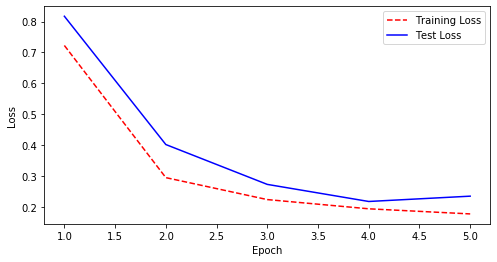

In [110]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Root Mean Square Error
##### During the training process above, model weights have been saved so that for every time the validation loss has improved and we can use that value to calculate the best validation Root Mean Square Error.

In [101]:
# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 2 = 0.8753


### Visualize the word cloud

In [23]:
from numpy import load
from numpy import savez_compressed

In [24]:
X = popular_movies[['userId', 'movieId']]
Y = popular_movies[['rating']]

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

In [26]:
num_users = np.max(np.vstack([x_train, x_test])[:,0]) + 1
num_movies = np.max(np.vstack([x_train, x_test])[:,1]) + 1

In [27]:
print("number of users are ",num_users)
print("number of movies are ",num_movies)

number of users are  611
number of movies are  134131


In [28]:
savez_compressed('x_train.npz', x_train)
savez_compressed('x_test.npz', x_test)
savez_compressed('y_train.npz', y_train)
savez_compressed('y_test.npz', y_test)

In [43]:
x_train.loc[:,][:500]

,userId,movieId
55204,366,68157
23342,160,1097
22509,153,7458
99608,610,1197
37746,256,1270
...,...,...
42797,288,3552
90597,590,733
36251,247,5952
5506,39,1500


In [25]:
embedding_model.layers[5].name

'Movie_Vector'

In [102]:
layer_output = embedding_model.get_layer('Movie_Vector').output

In [103]:
test_model = Model(movie_input, layer_output)

In [104]:
x_train[:,:]

array([[  366, 68157],
       [  160,  1097],
       [  153,  7458],
       ...,
       [  555,    19],
       [   17,  1210],
       [  230,   377]])

In [105]:
X_train_trm = test_model.predict(np.unique(x_train[:,1]))

In [106]:
X_test_trm = test_model.predict(np.unique(x_test[:,1]))

In [157]:
tsne = TSNE()
train_tsne_embedings = tsne.fit_transform(X_train_trm)
eval_tsne_embedings = tsne.fit_transform(X_test_trm)

### Scatter plot for tsne

In [158]:
def scatter(x, title, color='g'):
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=color)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.set_title(title)
    ax.axis('off')
    ax.axis('tight')

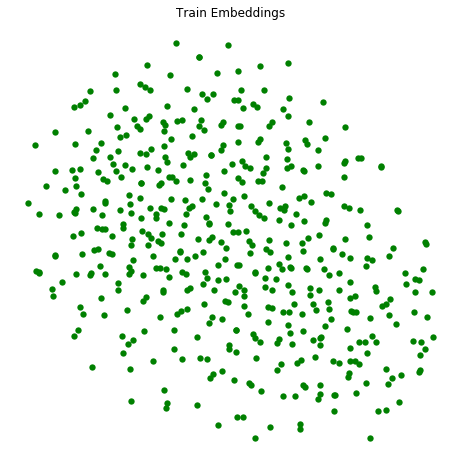

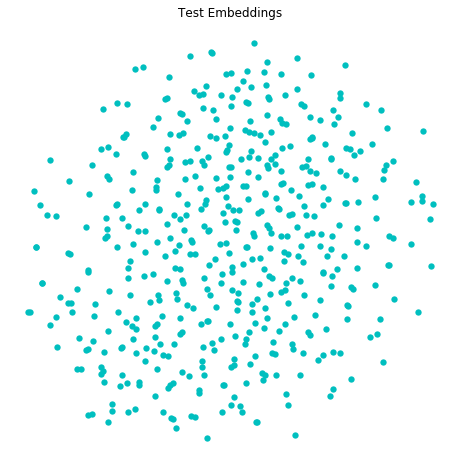

In [159]:
scatter(train_tsne_embedings, 'Train Embeddings')
scatter(eval_tsne_embedings, 'Test Embeddings', color='c')

Text(0.5, 1.0, 'Train Embeddings')

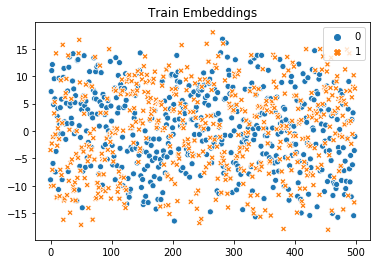

In [160]:
g =sns.scatterplot(
              hue="continent",
              data=train_tsne_embeds);
plt.title('Train Embeddings')

Text(0.5, 1.0, 'Test Embeddings')

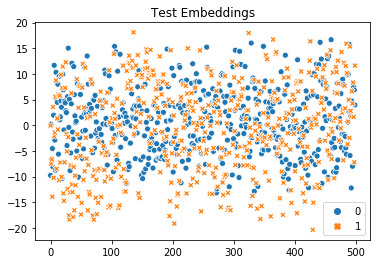

In [161]:
g =sns.scatterplot(
              hue="continent",
              data=eval_tsne_embeds);
plt.title('Test Embeddings')

### Movies Predicted

In [162]:
test_model.save('weights.h5')

In [163]:
emodel = tf.keras.models.load_model('weights.h5')

In [164]:
movies_recommended_ = np.unique(np.vstack([x_train, x_test])[:,1])

In [165]:
embeddings_drawn = emodel.predict(movies_recommended_)

In [167]:
knn = NearestNeighbors(n_neighbors=5)

In [169]:
knn.fit(embeddings_drawn,movies_recommended_)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [172]:
k = knn.kneighbors(emodel.predict(np.unique(x_test[:,1])),return_distance=False)

In [185]:
lines = []
lines.append("Movies\t  Recommendations")
for i,j in zip(np.unique(x_test[:,1]), k):
    lines.append(f'{i}\t  {j}\n')

In [188]:
for l in lines:
    print(l)

Movies	  Recommendations
1	  [  0 296 448  84 277]

2	  [  1  86 220 265  97]

3	  [  2 317 108  61 146]

5	  [  3 208 317 330 239]

6	  [  4 389 392 495 354]

7	  [  5  56 239  22 193]

10	  [  6 337 212  72  84]

11	  [  7 299 319 132  16]

16	  [  8 140 176 148 308]

17	  [  9  84 117 258 149]

19	  [ 10 417  77  72 381]

21	  [ 11 375 250  92 213]

25	  [ 12 327  92 250 393]

32	  [ 13 136  84 229 482]

34	  [ 14 326 455 422  63]

36	  [ 15 392 130 495 463]

39	  [ 16  84 120 326 394]

47	  [ 17 286 258 170 326]

48	  [ 18 116  56  83 287]

50	  [ 19 151 383  48 149]

62	  [ 20 100 360 438 243]

70	  [ 21 146  33 220  28]

95	  [ 22  41 414 223  83]

104	  [ 23  27 441 491 274]

110	  [ 24 104 353 364 217]

111	  [ 25 135 118 342 182]

112	  [ 26 302 394  64 265]

141	  [ 27 326  84  23 371]

145	  [ 28 146  74 386  21]

150	  [ 29 406 229 342 490]

153	  [ 30 381  41  76 376]

158	  [ 31 381  71  72  39]

160	  [ 32 189 461  61 328]

161	  [ 33 389  21 298 495]

163	  [ 34 452 102